In [1]:
%%capture
%run 04_alphaml_feat_eng.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from mle_quant_utils import quant_helper, quant_factors
import project_7_helper as project_helper

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")

In [4]:
import yaml
import os

# Retrieve parameters from configuration file
with open("../conf.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile)

OUTPATH =  "../data/" + cfg['output']['main'] + "/" + cfg['output']['alpha_factors_ml']['folder'] + "/"
OUTFILE1 = cfg['output']['alpha_factors_ml']['features']
OUTFILE2 = cfg['output']['alpha_factors_ml']['targets']

In [5]:
target_col = cfg['models']['alpha_ml']['target_col']

# IID Check of Target
Let's see if the returns are independent and identically distributed.

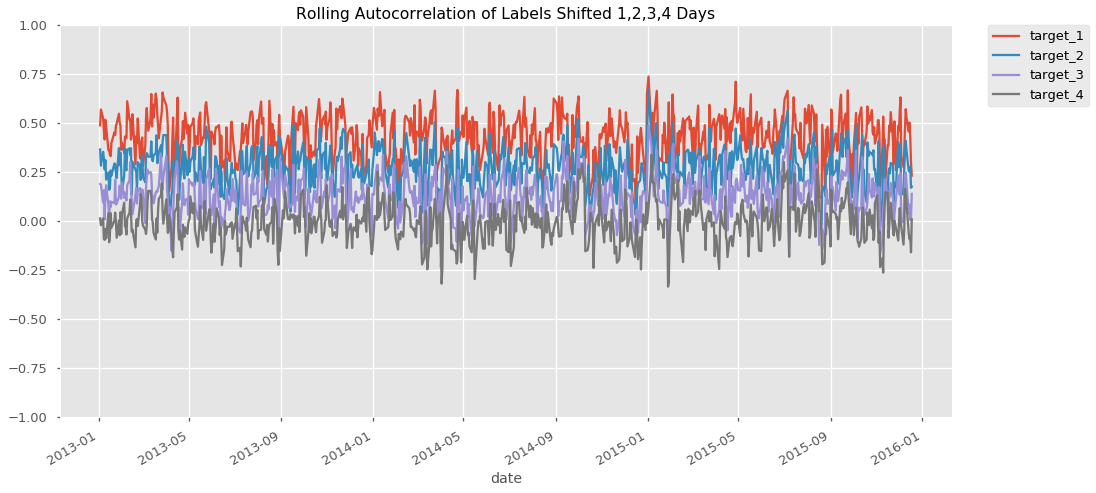

In [6]:
from scipy.stats import spearmanr


def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


targets_df['target_p'] = targets_df.groupby(level=1)['return_5d_5p'].shift(-5)
targets_df['target_1'] = targets_df.groupby(level=1)['return_5d'].shift(-4)
targets_df['target_2'] = targets_df.groupby(level=1)['return_5d'].shift(-3)
targets_df['target_3'] = targets_df.groupby(level=1)['return_5d'].shift(-2)
targets_df['target_4'] = targets_df.groupby(level=1)['return_5d'].shift(-1)

g = targets_df.dropna().groupby(level=0)
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

The longer the shift period the lower the correlation, this means that it is more difficult to forecast longer time periods. Moreover, in full data, target overlapping creates non-independent observations

# Train/Valid/Test Splits
Now let's split the data into a train, validation, and test dataset. Implement the function `train_valid_test_split` to split the input samples, `all_x`, and targets values, `all_y` into a train, validation, and test dataset. The proportion sizes are `train_size`, `valid_size`, `test_size` respectively.

When splitting, make sure the data is in order from train, validation, and test respectivly. Say `train_size` is 0.7, `valid_size` is 0.2, and `test_size` is 0.1. The first 70 percent of `all_x` and `all_y` would be the train set. The next 20 percent of `all_x` and `all_y` would be the validation set. The last 10 percent of `all_x` and `all_y` would be the test set. Make sure not split a day between multiple datasets. It should be contained within a single dataset.

In [7]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert isinstance(all_x.index, pd.MultiIndex)
    assert isinstance(all_x.index.get_level_values(0), pd.DatetimeIndex)
    assert isinstance(all_y.index, pd.MultiIndex)
    assert isinstance(all_y.index.get_level_values(0), pd.DatetimeIndex)
    
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    # TODO: Implement
    # Obtain an array of each split idx
    # Assume a MultiIndex pandas, level=0 is date
    n_rows = len(all_y)
    splits_idx = np.array([train_size, valid_size, test_size])*n_rows
    splits_idx = np.array(splits_idx).cumsum().astype(np.int32)
    # extract date index and slice it according to previous indeces 
    idx_dates = all_x.index.get_level_values(0)
    idx_train =  idx_dates[:splits_idx[0]]
    idx_valid = idx_dates[splits_idx[0]:splits_idx[1]]
    idx_test = idx_dates[splits_idx[1]:]
    # Split Multi index data
    x_train = all_x.loc[idx_train[0]: idx_train[-1]]
    y_train = all_y.loc[idx_train[0]: idx_train[-1]]
    
    x_valid = all_x.loc[idx_valid[0]: idx_valid[-1]]
    y_valid = all_y.loc[idx_valid[0]: idx_valid[-1]]
    
    x_test = all_x.loc[idx_test[0]: idx_test[-1]]
    y_test = all_y.loc[idx_test[0]: idx_test[-1]]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test


With `train_valid_test_split` implemented, let's split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [8]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(all_factors, targets_df['target'], 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
date                      asset                                           
2013-01-03 00:00:00+00:00 A                                   -0.795709   
                          AAL                                  0.558847   
                          AAP                                 -1.054777   
                          AAPL                                -1.128796   
                          ABBV                                -0.599557   

                                 Momentum_1YR_Smoothed  \
date                      asset                          
2013-01-03 00:00:00+00:00 A                  -1.230279   
                          AAL                 1.713471   
                          AAP                -1.535061   
                          AAPL                1.148508   
                          ABBV                0.341951   

                                 Overnight_Sentiment_Smoothed  adv_120d  \
date                      asset                                           
2013-01-03 00:00:00+00:00 A                         -1.301799  1.338573   
                          AAL                       -1.632765  1.139994   
                          AAP                        1.022317 -0.301547   
                          AAPL                       0.066193  1.728377   
                          ABBV                      -1.691603 -1.728377   

                                  adv_20d  dispersion_120d  dispersion_20d  \
date                      asset                                              
2013-01-03 00:00:00+00:00 A      1.397411         0.013270        0.011178   
                          AAL    1.081155         0.013270        0.011178   
                          AAP   -0.919350         0.013270        0.011178   
                          AAPL   1.728377         0.013270        0.011178   
                          ABBV  -1.647475         0.014595        0.014595   

                                 market_vol_120d  market_vol_20d  \
date                      asset                                    
2013-01-03 00:00:00+00:00 A             0.127654        0.135452   
                          AAL           0.127654        0.135452   
                          AAP           0.127654        0.135452   
                          AAPL          0.127654        0.135452   
                          ABBV          0.127654        0.135452   

                                 volatility_120d    ...      sector_code_10  \
date                      asset                     ...                       
2013-01-03 00:00:00+00:00 A            -0.836546    ...                   0   
                          AAL           1.639924    ...                   0   
                          AAP           1.072400    ...                   0   
                          AAPL          1.050289    ...                   0   
                          ABBV         -0.073704    ...                   0   

                                 qtr_1  qtr_2  qtr_3  qtr_4  weekday_0  \
date                      asset                                          
2013-01-03 00:00:00+00:00 A          1      0      0      0          0   
                          AAL        1      0      0      0          0   
                          AAP        1      0      0      0          0   
                          AAPL       1      0      0      0          0   
                          ABBV       1      0      0      0          0   

                                 weekday_1  weekday_2  weekday_3  weekday_4  
date                      asset                                              
2013-01-03 00:00:00+00:00 A              0          0          1          0  
                          AAL            0          0          1          0  
                          AAP            0          0          1          0  
                          AAPL           0          0          1          0  
         

## Random Forests

### Question: Why does dispersion_20d have the highest feature importance, when the first split is on the Momentum_1YR feature?
*#TODO: Put Answer In this Cell*

Splits are based on impurity reduction, that's it, select the feature-split that greedly yields a greater impurity reduction. When the tree is fully grown, node importances are computed and lower nodes tend to accomplish a greater importance due to better splitting capability, therefore, features used in that later nodes tend to be more important in this calculation


### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [10]:
n_days = 10
n_stocks = 500
clf_random_state = 123
clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 500, 1000]

Recall from the lesson, that we’ll choose a min_samples_leaf parameter to be small enough to allow the tree to fit the data with as much detail as possible, but not so much that it overfits.  We can first propose 500, which is the number of assets in the estimation universe. Since we have about 500 stocks in the stock universe, we’ll want at least 500 stocks in a leaf for the leaf to make a prediction that is representative.  It’s common to multiply this by 2,3,5 or 10, so we’d have min samples leaf of 500, 1000, 1500, 2500, and 5000. If we were to try these values, we’d notice that the model is “too good to be true” on the training data.  A good rule of thumb for what is considered “too good to be true”, and therefore a sign of overfitting, is if the sharpe ratio is greater than 4.  Based on this, we recommend using min_sampes_leaf of 10 * 500, or 5,000.

Feel free to try other values for these parameters, but also keep in mind that making too many small adjustments to hyper-parameters can lead to overfitting even the validation data, and therefore lead to less generalizable performance on the out-of-sample test set.  So when trying different parameter values, choose values that are different enough in scale (i.e. 10, 20, 100 instead of 10,11,12).

In [11]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [02:42<00:00, 32.60s/Model]


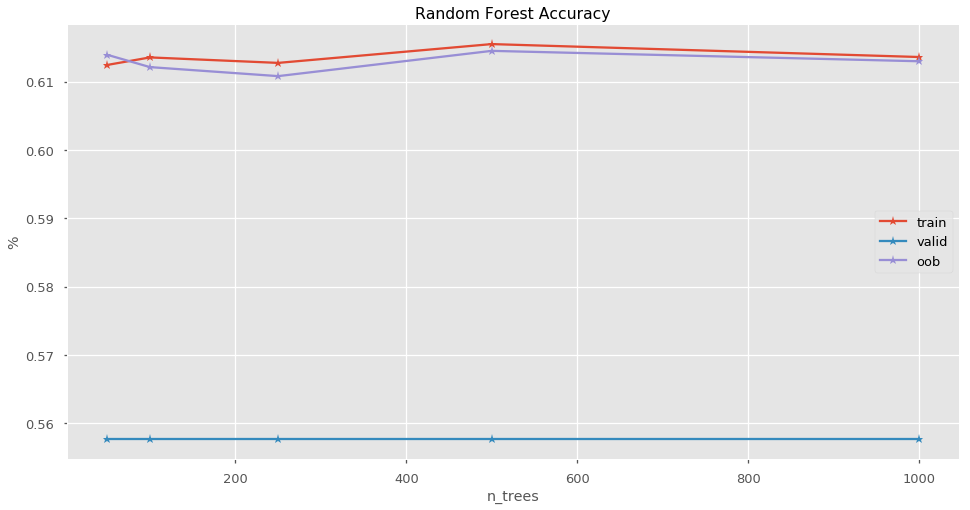

In [12]:
rf_raw = pd.DataFrame(index=n_trees_l, columns=['train', 'valid', 'oob'])
rf_raw['train'] = train_score
rf_raw['valid'] = valid_score
rf_raw['oob'] = oob_score
rf_raw.plot(marker='*', title='Random Forest Accuracy')
plt.ylabel('%')
plt.xlabel('n_trees')
plt.show()

In [13]:
rf_raw

,train,valid,oob
50,0.612425,0.55763,0.613909
100,0.613527,0.55763,0.612107
250,0.612725,0.55763,0.610789
500,0.615476,0.55763,0.614485
1000,0.613587,0.55763,0.612964


#### Question: 1) What do you observe with the accuracy vs tree size graph? 2) Does the graph indicate the model is overfitting or underfitting? Describe how it indicates this.
*#TODO: Put Answer In this Cell*

1. Validation curve plateaus below 50%, in a multiclass problem is better than random guessing
2. Adding too many trees (more than 100 more or less) indicates that the model is overfitting, because validation accuracy drops



Now let's looks at the average feature importance of the classifiers.

In [14]:
print('Features Ranked by Average Importance:\n')
project_helper.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                    Importance
 1. market_vol_20d                         (0.4042977003938111)
 2. market_vol_120d                        (0.19118111114087355)
 3. dispersion_120d                        (0.16377237799283662)
 4. dispersion_20d                         (0.15167538033777336)
 5. qtr_3                                  (0.019343657496758763)
 6. qtr_1                                  (0.014762082279201347)
 7. qtr_2                                  (0.011406821292758076)
 8. qtr_4                                  (0.008599216992482917)
 9. volatility_120d                        (0.0076934827398783545)
10. volatility_20d                         (0.005512483956981279)
11. weekday_0                              (0.004050542016709747)
12. is_January                             (0.0036416709786522296)
13. weekday_4                              (0.0025446220151351374)
14. is_December                            (

You might notice that some of the features of low to no importance. We will be removing them when training the final model.
### Model Results
Let's look at some additional metrics to see how well a model performs. We've created the function `show_sample_results` to show the following results of a model:
- Sharpe Ratios
- Factor Returns
- Factor Rank Autocorrelation

In [15]:
import alphalens as al


all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = quant_helper.get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = project_helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = project_helper.get_factor_returns(factor_data)
    sharpe_ratio = project_helper.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    project_helper.plot_factor_returns(factor_returns)
    project_helper.plot_factor_rank_autocorrelation(factor_data)

NameError: name 'data_portal' is not defined

#### Results
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [ ]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR_Smoothed',
    'Overnight_Sentiment_Smoothed',
    'adv_120d',
    'volatility_20d']

##### Training Prediction
Let's see how well the model runs on training data.

In [ ]:
show_sample_results(all_factors, X_train, clf, factor_names)

##### Validation Prediction
Let's see how well the model runs on validation data.

In [ ]:
show_sample_results(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

## Overlapping Samples
Let's fix this by removing overlapping samples. We can do a number of things:

- Don't use overlapping samples
- Use BaggingClassifier's `max_samples`
- Build an ensemble of non-overlapping trees

In this project, we'll do all three methods and compare.
### Drop Overlapping Samples
This is the simplest of the three methods. We'll just drop any overlapping samples from the dataset. Implement the `non_overlapping_samples` function to return a new dataset overlapping samples. 

In [ ]:
def non_overlapping_samples(x, y, n_skip_samples, start_i=0):
    """
    Get the non overlapping samples.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    n_skip_samples : int
        The number of samples to skip
    start_i : int
        The starting index to use for the data
    
    Returns
    -------
    non_overlapping_x : 2 dimensional Ndarray
        The non overlapping input samples
    non_overlapping_y : 1 dimensional Ndarray
        The non overlapping target values
    """
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    
    # TODO: Implement
    #Get dates index
    # Assume that input dataframe is MultiIndex and level=0 is a date 
    idx_dates = x.index.levels[0]
    n_dates = len(idx_dates)
    # Get a vector of indeces that represent the sample,
    # subset then from idx_date and cast to a list of pd.Timestamps
    subset_idx_dates = np.arange(start_i, n_dates, n_skip_samples+1)
    subset_dates = [pd.Timestamp(dt) for dt in idx_dates[subset_idx_dates]]
    # Subset pandas DFs
    non_overlapping_x = x.loc[subset_dates]
    non_overlapping_y = y.loc[subset_dates]
    
    return non_overlapping_x, non_overlapping_y


project_tests.test_non_overlapping_samples(non_overlapping_samples)

With the dataset created without overlapping samples, lets train a new model and look at the results.

#### Train Model

In [ ]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

#### Results

In [ ]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [ ]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This looks better, but we are throwing away a lot of information by taking every 5th row.

### Use BaggingClassifier's `max_samples`
In this method, we'll set `max_samples` to be on the order of the average uniqueness of the labels. Since  `RandomForrestClassifier` does not take this param, we're using `BaggingClassifier`. Implement `bagging_classifier` to build the bagging classifier.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


def bagging_classifier(n_estimators, max_samples, max_features, parameters):
    """
    Build the bagging classifier.

    Parameters
    ----------
    n_estimators : int 
        The number of base estimators in the ensemble
    max_samples : float 
        The proportion of input samples drawn from when training each base estimator
    max_features : float 
        The proportion of input sample features drawn from when training each base estimator
    parameters : dict
        Parameters to use in building the bagging classifier
        It should contain the following parameters:
            criterion
            min_samples_leaf
            oob_score
            n_jobs
            random_state
    
    Returns
    -------
    bagging_clf : Scikit-Learn BaggingClassifier
        The bagging classifier
    """
    
    required_parameters = {'criterion', 'min_samples_leaf', 'oob_score', 'n_jobs', 'random_state'}
    assert not required_parameters - set(parameters.keys())
    
    # TODO: Implement
    dtc = DecisionTreeClassifier(criterion=parameters['criterion'],
                                 min_samples_leaf=parameters['min_samples_leaf'],
                                 random_state=parameters['random_state'])
    clf = BaggingClassifier(
        base_estimator = dtc,
        n_estimators = n_estimators,
        max_samples = max_samples,
        random_state = parameters['random_state'],
        oob_score = parameters['oob_score'],
        n_jobs = parameters['n_jobs']
    )
    return clf


project_tests.test_bagging_classifier(bagging_classifier)

With the bagging classifier built, lets train a new model and look at the results.
#### Train Model

In [ ]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = bagging_classifier(n_trees, 0.2, 1.0, clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

#### Results

In [ ]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [ ]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This seems much "better" in the sense that we have much better fidelity between the three.


### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [ ]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

You might notice that two of the functions are abstracted. These will be the functions that you need to implement.
#### OOB Score
In order to get the correct OOB score, we need to take the average of all the estimator's OOB scores. Implement `calculate_oob_score` to calculate this score.

In [ ]:
def calculate_oob_score(classifiers):
    """
    Calculate the mean out-of-bag score from the classifiers.

    Parameters
    ----------
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to calculate the mean out-of-bag score
    
    Returns
    -------
    oob_score : float
        The mean out-of-bag score
    """
    
    # TODO: Implement
    oob_scores = np.array([clf.oob_score_ for clf in classifiers])  # (n_clfs x n_oob_samples)
    oob_score = oob_scores.mean()
    return oob_score


project_tests.test_calculate_oob_score(calculate_oob_score)

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [ ]:
def non_overlapping_estimators(x, y, classifiers, n_skip_samples):
    """
    Fit the classifiers to non overlapping data.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to fit on the non overlapping data
    n_skip_samples : int
        The number of samples to skip
    
    Returns
    -------
    fit_classifiers : list of Scikit-Learn Classifiers
        The classifiers fit to the the non overlapping data
    """
    
    # TODO: Implement
    # Generate N non-overlapping samples and fit a classifier for each
    n_clfs = len(classifiers)
    fit_classifiers = []
    for idx, offset in enumerate(range(0, n_clfs)):
        x_smpl, y_smpl = non_overlapping_samples(x, y, n_skip_samples, offset)
        clf = classifiers[idx]
        fit_classifiers.append(clf.fit(x_smpl, y_smpl))
        
    
    return fit_classifiers


project_tests.test_non_overlapping_estimators(non_overlapping_estimators)

In [ ]:
class NoOverlapVoter(NoOverlapVoterAbstract):
    def _calculate_oob_score(self, classifiers):
        return calculate_oob_score(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        return non_overlapping_estimators(x, y, classifiers, n_skip_samples)

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

In [ ]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

#### Results

In [ ]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [ ]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [ ]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

### Results
#### Accuracy

In [ ]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

#### Train

In [ ]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

In [ ]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

#### Test

In [ ]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

So, hopefully you are appropriately amazed by this. Despite the significant differences between the factor performances in the three sets, the AI APLHA is able to deliver positive performance.

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.